# Kesten Processes and Firm Dynamics


<a id='index-0'></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import quantecon as qe

C:\Users\Diogo\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

[*********************100%***********************]  1 of 1 completed


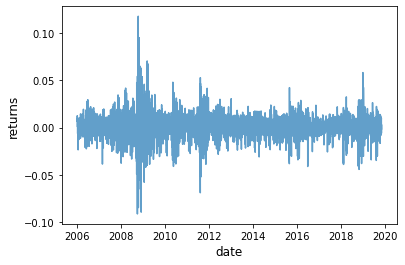

In [3]:
import yfinance as yf
import pandas as pd

s = yf.download('^IXIC', '2006-1-1', '2019-11-1')['Adj Close']

r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, alpha=0.7)

ax.set_ylabel('returns', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()

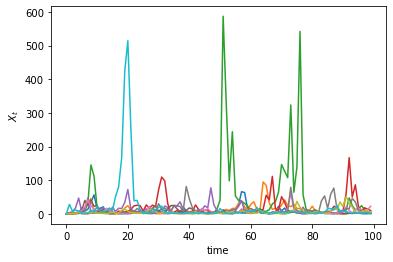

In [4]:
μ = -0.5
σ = 1.0

def kesten_ts(ts_length=100):
    x = np.zeros(ts_length)
    for t in range(ts_length-1):
        a = np.exp(μ + σ * np.random.randn())
        b = np.exp(np.random.randn())
        x[t+1] = a * x[t] + b
    return x

fig, ax = plt.subplots()

num_paths = 10
np.random.seed(12)

for i in range(num_paths):
    ax.plot(kesten_ts())

ax.set(xlabel='time', ylabel='$X_t$')
plt.show()

In [5]:
μ_a = -0.5        # location parameter for a
σ_a = 0.1         # scale parameter for a
μ_b = 0.0         # location parameter for b
σ_b = 0.5         # scale parameter for b
μ_e = 0.0         # location parameter for e
σ_e = 0.5         # scale parameter for e
s_bar = 1.0       # threshold
T = 500           # sampling date
M = 1_000_000     # number of firms
s_init = 1.0      # initial condition for each firm

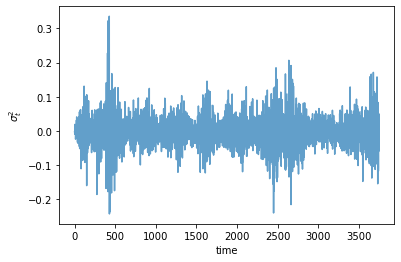

In [6]:
α_0 = 1e-5
α_1 = 0.1
β = 0.9

years = 15
days = years * 250

def garch_ts(ts_length=days):
    σ2 = 0
    r = np.zeros(ts_length)
    for t in range(ts_length-1):
        ξ = np.random.randn()
        σ2 = α_0 + σ2 * (α_1 * ξ**2 + β)
        r[t] = np.sqrt(σ2) * np.random.randn()
    return r

fig, ax = plt.subplots()

np.random.seed(12)

ax.plot(garch_ts(), alpha=0.7)

ax.set(xlabel='time', ylabel='$\\sigma_t^2$')
plt.show()

In [7]:
from numba import njit, prange
from numpy.random import randn


@njit(parallel=True)
def generate_draws(μ_a=-0.5,
                   σ_a=0.1,
                   μ_b=0.0,
                   σ_b=0.5,
                   μ_e=0.0,
                   σ_e=0.5,
                   s_bar=1.0,
                   T=500,
                   M=1_000_000,
                   s_init=1.0):

    draws = np.empty(M)
    for m in prange(M):
        s = s_init
        for t in range(T):
            if s < s_bar:
                new_s = np.exp(μ_e + σ_e *  randn())
            else:
                a = np.exp(μ_a + σ_a * randn())
                b = np.exp(μ_b + σ_b * randn())
                new_s = a * s + b
            s = new_s
        draws[m] = s

    return draws

data = generate_draws()

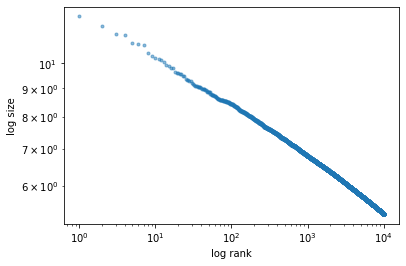

In [8]:
fig, ax = plt.subplots()

qe.rank_size_plot(data, ax, c=0.01)

plt.show()